In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [116]:
# data = pd.read_csv('data_preprocessed/data_combined_4000.csv', index_col='Unnamed: 0')
data = pd.read_csv('data_preprocessed/data_new_featured_3511.csv', index_col='Unnamed: 0')
# data = data.loc[:2200, :]

In [117]:
X = data.drop(['Result'], axis=1)
y = data['Result']

In [119]:
red_cols = [col for col in data.columns if col.find('Red') > -1]
blue_cols = [col for col in data.columns if col.find('Blue') > -1]

data[red_cols]

,RedStance,Red_Blue_Loss_diff,Red_Blue_curr_streak_diff
1,0.0,0,-2
2,0.0,-2,-3
3,1.0,0,1
4,0.0,0,0
5,1.0,-8,2
...,...,...,...
6508,1.0,4,-2
6512,1.0,2,0
6518,0.0,-3,3
6521,0.0,3,-1


In [16]:
# # Отображение первых двух признаков
# plt.scatter(X.values[:, 4], X.values[:, 12], c=y)
# plt.xlabel('Признак 1')
# plt.ylabel('Признак 2')
# plt.title('Сгенерированные данные')
# plt.show()

In [120]:
test_size = int(len(X)*0.25)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

In [121]:
scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [122]:
X_test

,RedStance,BlueStance,Age_diff,Height_diff,Reach_diff,Weight_diff,WinsByKO/TKO_diff,WinsBySubmission_diff,WinsByDecision_diff,Red_Blue_Loss_diff,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Red_Blue_curr_streak_diff
1,-0.592258,-0.626241,0.456005,-0.801750,0.911757,-0.019151,-1.024700,2.171525,-2.131336,-0.199783,-0.382682,0.459433,0.364793,-0.890908,1.646049,-1.215945,-0.778724,0.758976,-0.752704
2,-0.592258,-0.626241,-0.495601,-1.206466,0.295276,-0.616813,-1.024700,0.323299,-1.005998,-0.808844,0.145543,0.217715,0.031688,-1.404329,0.298831,1.054900,-0.884999,1.150941,-1.126431
3,1.688454,1.596830,-1.256885,0.412399,-0.012964,-0.019151,-0.212586,-0.138757,1.994906,-0.199783,-0.400897,1.104015,1.640753,0.456821,1.196976,1.963238,0.496575,-0.920875,0.368477
4,-0.592258,-0.626241,0.456005,-0.397034,0.603517,-0.019151,-1.430757,0.785356,0.494454,-0.199783,0.594838,-0.588013,0.099438,0.071755,0.186563,-0.307607,-0.194212,0.423006,-0.005250
5,1.688454,-0.626241,-0.495601,0.007683,0.295276,-0.019151,-1.430757,-2.449039,-0.255772,-2.636026,0.531086,0.056569,-0.103812,0.007578,-0.374778,1.054900,-2.532260,0.059038,0.742204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,-0.592258,1.596830,0.265684,0.007683,0.295276,-0.019151,0.599527,0.785356,-0.255772,-0.199783,-0.057854,1.345733,0.172834,-1.211796,0.635635,0.146562,-0.034800,-1.424830,1.863386
961,-0.592258,1.596830,-0.685922,0.412399,0.911757,-0.019151,-0.618643,-0.138757,-0.255772,0.104747,-0.531435,-1.393740,-0.041708,-0.056600,0.298831,-0.761776,-0.141074,-0.892877,-0.378977
962,1.688454,-0.626241,1.026968,0.412399,-0.321204,-1.214475,-0.212586,-0.138757,-0.630885,-0.199783,0.455192,-1.474313,-0.380458,-0.762553,-0.711583,-0.761776,-0.513037,-1.144855,-0.005250
964,1.688454,-0.626241,-0.685922,0.412399,0.295276,-0.019151,0.193471,-0.138757,-0.255772,-0.504313,0.464299,0.781724,0.607564,1.355307,-2.171069,0.146562,-0.194212,-0.556907,0.742204


### Загрузка данных

In [123]:
# Определение датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx]
        y = self.y.iloc[idx]  # берем только первый столбец (класс)
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }  
    
# Загрузка данных
X = X_train
y = y_train

# Создание датасета и даталоадера
# Создание датасета и даталоадера
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Базовая модель. 3 слоя

In [127]:
# Определение нейронной сети
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(19, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой 

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)              

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.fc3(x)
        return x      

### Больше слоев

In [133]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(19, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 32)  # скрытый слой
        self.fc4 = nn.Linear(32, 2)  # выходной слой

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight) 
        nn.init.kaiming_normal_(self.fc3.weight) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.fc4(x)
        return x

### Добавляем дропаут

In [139]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(19, 128)  # входной слой
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 128)  # скрытый слой
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 64)  # скрытый слой
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(64, 64)  # скрытый слой
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(64, 32)  # скрытый слой
        self.dropout5 = nn.Dropout(p=0.2)
        self.fc6 = nn.Linear(32, 2)  # выходной слой   

    def forward(self, x):        
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  # активация ReLU
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))  # активация ReLU
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

### Разные функции активации

In [63]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # функция активации sigmoid
        x = torch.sigmoid(self.fc2(x))  # функция активации sigmoid
        x = self.fc3(x)
        return x

### Тестируем модель

In [154]:
# Инициализация нейронной сети и оптимизатора
net = FighterNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Обучение нейронной сети
for epoch in range(40):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.6853215098381042
Эпоха 2, потеря: 0.6506227254867554
Эпоха 3, потеря: 0.5783383846282959
Эпоха 4, потеря: 0.6119574308395386
Эпоха 5, потеря: 0.7153205275535583
Эпоха 6, потеря: 0.6583666205406189
Эпоха 7, потеря: 0.5747092366218567
Эпоха 8, потеря: 0.5075346231460571
Эпоха 9, потеря: 0.6586447954177856
Эпоха 10, потеря: 0.7187987565994263
Эпоха 11, потеря: 0.5771378874778748
Эпоха 12, потеря: 0.671495795249939
Эпоха 13, потеря: 0.6275410056114197
Эпоха 14, потеря: 0.4938472807407379
Эпоха 15, потеря: 0.8080002069473267
Эпоха 16, потеря: 0.6727941036224365
Эпоха 17, потеря: 0.7791290879249573
Эпоха 18, потеря: 0.6388293504714966
Эпоха 19, потеря: 0.6861981749534607
Эпоха 20, потеря: 0.7225583791732788
Эпоха 21, потеря: 0.6740514039993286
Эпоха 22, потеря: 0.5970026254653931
Эпоха 23, потеря: 0.585545003414154
Эпоха 24, потеря: 0.6100879907608032
Эпоха 25, потеря: 0.626205563545227
Эпоха 26, потеря: 0.5959677696228027
Эпоха 27, потеря: 0.6743796467781067
Эпоха 28, пот

f1_score: 0.599
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       496
           1       0.57      0.42      0.48       381

    accuracy                           0.61       877
   macro avg       0.60      0.59      0.59       877
weighted avg       0.60      0.61      0.60       877



Text(0.5, 23.52222222222222, 'predicted value')

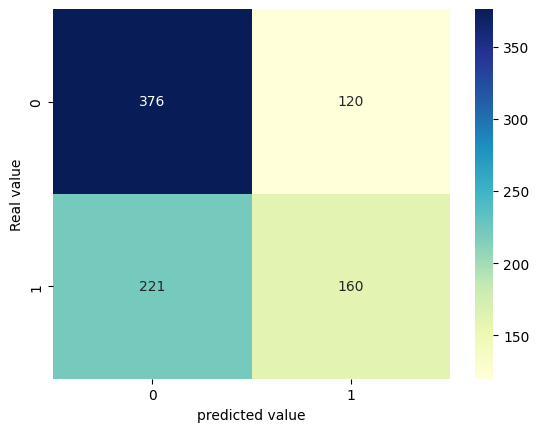

In [155]:
# Оценка модели на тестовых данных
net.eval()
test_y_pred_proba = []
test_y_true = []
test_y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        test_y_pred.extend(predicted.cpu().numpy())
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        test_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        test_y_true.extend(y.cpu().numpy())

# Матрица ошибок
print(f'f1_score: {f1_score(test_y_true, test_y_pred, average='weighted'):.3f}')
test_y_pred = np.argmax(test_y_pred_proba, axis=1)
test_cm = confusion_matrix(test_y_true, test_y_pred)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(test_y_true, test_y_pred))


sns.heatmap(test_cm,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

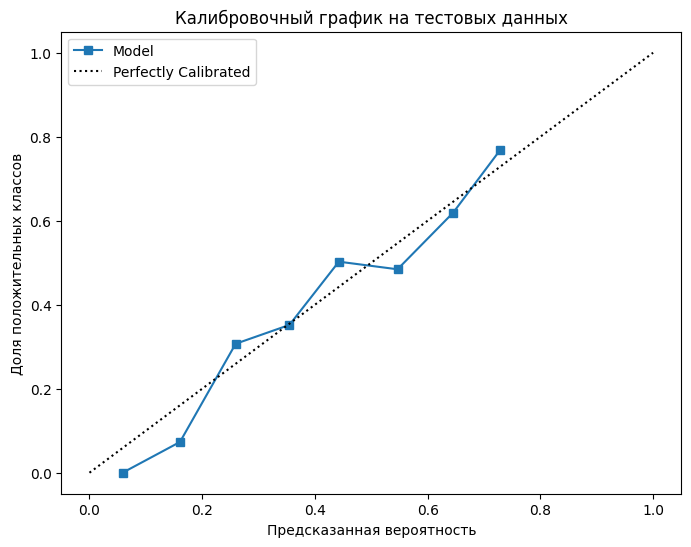

In [156]:
# Калибровочный график
plt.figure(figsize=(8, 6))
test_y_pred_proba_array = np.array(test_y_pred_proba)
fraction_of_positives, mean_predicted_value = calibration_curve(test_y_true, test_y_pred_proba_array[:, 1], n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives,'s-', label='Model')
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля положительных классов')
plt.title('Калибровочный график на тестовых данных')
plt.legend()
plt.show()

### Label Smoothing

In [74]:
# Определение функции потерь с label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets):
        n_classes = inputs.size(1)
        one_hot_targets = torch.zeros_like(inputs)
        one_hot_targets.scatter_(1, targets.long().unsqueeze(1), 1)
        smoothed_targets = (1 - self.alpha) * one_hot_targets + self.alpha / n_classes
        loss = nn.KLDivLoss()(inputs, smoothed_targets)
        return loss

In [75]:
net = FighterNet()
criterion = LabelSmoothingLoss(alpha=0.01)

# Обучение нейронной сети
for epoch in range(20):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.015448076650500298
Эпоха 2, потеря: 0.024768566712737083
Эпоха 3, потеря: 0.028100240975618362
Эпоха 4, потеря: 0.01611032709479332
Эпоха 5, потеря: 0.015280038118362427
Эпоха 6, потеря: 0.023966867476701736
Эпоха 7, потеря: 0.026725346222519875
Эпоха 8, потеря: 0.01681497134268284
Эпоха 9, потеря: 0.022031620144844055
Эпоха 10, потеря: 0.020985180512070656
Эпоха 11, потеря: 0.02310132049024105
Эпоха 12, потеря: 0.021704386919736862
Эпоха 13, потеря: 0.02743193507194519
Эпоха 14, потеря: 0.019289299845695496
Эпоха 15, потеря: 0.021735748276114464
Эпоха 16, потеря: 0.028725579380989075
Эпоха 17, потеря: 0.02127106487751007
Эпоха 18, потеря: 0.02111692912876606
Эпоха 19, потеря: 0.026395713910460472
Эпоха 20, потеря: 0.01808885484933853


f1_score: 0.411
Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.72       496
           1       0.50      0.00      0.01       381

    accuracy                           0.57       877
   macro avg       0.53      0.50      0.36       877
weighted avg       0.54      0.57      0.41       877



Text(0.5, 23.52222222222222, 'predicted value')

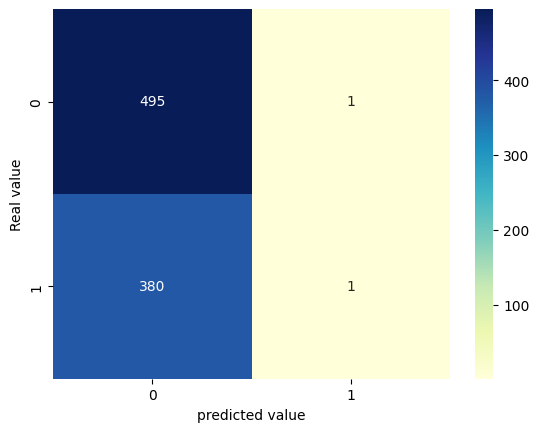

In [76]:
# Оценка модели на тестовых данных
net.eval()
test_y_pred_proba = []
test_y_true = []
test_y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        test_y_pred.extend(predicted.cpu().numpy())
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        test_y_pred_proba.extend(y_pred_proba.cpu().numpy())
        test_y_true.extend(y.cpu().numpy())

# Матрица ошибок
print(f'f1_score: {f1_score(test_y_true, test_y_pred, average='weighted'):.3f}')
test_y_pred = np.argmax(test_y_pred_proba, axis=1)
test_cm = confusion_matrix(test_y_true, test_y_pred)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(test_y_true, test_y_pred))


sns.heatmap(test_cm,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Сиамская сеть

In [77]:
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [78]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(36, 128)  # Измените 38 на 20
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x1 = torch.relu(self.fc1(x1))
        x1 = torch.relu(self.fc2(x1))
        x1 = self.fc3(x1)

        x2 = torch.relu(self.fc1(x2))
        x2 = torch.relu(self.fc2(x2))
        x2 = self.fc3(x2)

        outputs = torch.sigmoid(x1 - x2)
        return outputs

In [79]:
# Обучение сиамской нейросети
model = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        mid = len(x) // 2
        x1 = x[:mid]
        x2 = x[mid:mid + mid]
        outputs = model(x1, x2)
        loss = criterion(outputs, y[:mid].view(-1, 1).float())
        loss.backward()
        optimizer.step()
        print(f'Эпоха {epoch+1}, потеря: {loss.item()}') 

# Оценка сиамской нейросети
y_pred = []
for batch in test_dataloader:
    x = batch['x']
    output = model(x, x)  # используйте каждое входное данные как пару
    y_pred.extend((output > 0.5).int().cpu().numpy())

print(f'Точность: {accuracy_score(y_test, y_pred)}')
print(f'Полнота: {precision_score(y_test, y_pred)}')
print(f'Полнота: {recall_score(y_test, y_pred)}')
print(f'F1-мера: {f1_score(y_test, y_pred)}')

Эпоха 1, потеря: 0.6891972422599792
Эпоха 1, потеря: 0.6911141872406006
Эпоха 1, потеря: 0.7876951694488525
Эпоха 1, потеря: 0.6395604610443115
Эпоха 1, потеря: 0.7202768921852112
Эпоха 1, потеря: 0.8554220199584961
Эпоха 1, потеря: 0.8213168382644653
Эпоха 1, потеря: 0.6596053838729858
Эпоха 1, потеря: 0.8252978324890137
Эпоха 1, потеря: 0.7223699688911438
Эпоха 1, потеря: 0.8166611790657043
Эпоха 1, потеря: 0.6583518981933594
Эпоха 1, потеря: 0.8004550933837891
Эпоха 1, потеря: 0.8268249034881592
Эпоха 1, потеря: 0.7959235310554504
Эпоха 1, потеря: 0.75892573595047
Эпоха 1, потеря: 0.651748776435852
Эпоха 1, потеря: 0.884284257888794
Эпоха 1, потеря: 0.8426386713981628
Эпоха 1, потеря: 0.7422946691513062
Эпоха 1, потеря: 0.7813051342964172
Эпоха 1, потеря: 0.8177675604820251
Эпоха 1, потеря: 0.8091974258422852
Эпоха 1, потеря: 0.8233544826507568
Эпоха 1, потеря: 0.8228877782821655
Эпоха 1, потеря: 0.7534818053245544
Эпоха 1, потеря: 0.7839336395263672
Эпоха 1, потеря: 0.7497423887252

### Эмбеддинг-нейросеть + Предсказательная нейросеть

In [80]:
# Инициализация моделей
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(EmbeddingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PredictionNetwork(nn.Module):
    def __init__(self, embedding_dim):
        super(PredictionNetwork, self).__init__()
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [81]:
# Инициализация моделей
embedding_network = EmbeddingNetwork(input_dim=18, embedding_dim=180)
prediction_network = PredictionNetwork(embedding_dim=180)

# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(embedding_network.parameters()) + list(prediction_network.parameters()), lr=0.001)

# Обучение моделей
for epoch in range(60):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Расчет потерь
        loss = criterion(outputs, y.view(-1, 1).float())

        # Обратное распространение ошибок
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.7115370631217957
Эпоха 2, потеря: 0.6372442841529846
Эпоха 3, потеря: 0.69806307554245
Эпоха 4, потеря: 0.6873332262039185
Эпоха 5, потеря: 0.5672797560691833
Эпоха 6, потеря: 0.41341811418533325
Эпоха 7, потеря: 0.5541454553604126
Эпоха 8, потеря: 0.5600582957267761
Эпоха 9, потеря: 0.4729817807674408
Эпоха 10, потеря: 0.5941950678825378
Эпоха 11, потеря: 0.4575181007385254
Эпоха 12, потеря: 0.7440321445465088
Эпоха 13, потеря: 0.4572972357273102
Эпоха 14, потеря: 0.6496633291244507
Эпоха 15, потеря: 0.7102056741714478
Эпоха 16, потеря: 0.5451400876045227
Эпоха 17, потеря: 0.40621742606163025
Эпоха 18, потеря: 0.7846857309341431
Эпоха 19, потеря: 0.35813575983047485
Эпоха 20, потеря: 0.4249453544616699
Эпоха 21, потеря: 0.5268616080284119
Эпоха 22, потеря: 0.30875521898269653
Эпоха 23, потеря: 0.4086264669895172
Эпоха 24, потеря: 0.36167746782302856
Эпоха 25, потеря: 0.17621973156929016
Эпоха 26, потеря: 0.25116562843322754
Эпоха 27, потеря: 0.18653306365013123
Эпох

In [82]:
# Оценка модели на тестовой выборке
embedding_network.eval()
prediction_network.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Преобразование выходных данных в бинарные метки
        pred = torch.sigmoid(outputs) > 0.5
        y_pred.extend(pred.int().cpu().numpy())
        y_true.extend(y.int().cpu().numpy())

# Расчет F1-меры
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f'F1-мера: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1-мера: 0.5211
Accuracy: 0.5849
Precision: 0.5224
Recall: 0.5197


### Сиамская сеть + Label Smoothing

In [16]:
# Инициализация моделей
embedding_network = EmbeddingNetwork(input_dim=18, embedding_dim=180)
prediction_network = PredictionNetwork(embedding_dim=180)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets):
        n_classes = 2
        targets = targets.long()
        one_hot_targets = torch.zeros(targets.shape[0], n_classes, device=targets.device)
        one_hot_targets[range(targets.shape[0]), targets] = 1
        smoothed_targets = (1 - self.alpha) * one_hot_targets + self.alpha / n_classes
        inputs = torch.sigmoid(inputs)
        inputs = torch.cat((1 - inputs, inputs), dim=1)
        loss = nn.KLDivLoss()(inputs, smoothed_targets)
        return loss

criterion = LabelSmoothingLoss(alpha=0.01)
optimizer = optim.Adam(list(embedding_network.parameters()) + list(prediction_network.parameters()), lr=0.001)

# Обучение моделей
for epoch in range(40):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Расчет потерь
        loss = criterion(outputs, y)

        # Обратное распространение ошибок
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: -0.29546210169792175
Эпоха 2, потеря: -0.2954695224761963
Эпоха 3, потеря: -0.255839079618454
Эпоха 4, потеря: -0.2756251394748688
Эпоха 5, потеря: -0.2954511344432831
Эпоха 6, потеря: -0.3548354208469391
Эпоха 7, потеря: -0.27564486861228943
Эпоха 8, потеря: -0.39443352818489075
Эпоха 9, потеря: -0.29544153809547424
Эпоха 10, потеря: -0.3152115046977997
Эпоха 11, потеря: -0.2558518648147583
Эпоха 12, потеря: -0.31523144245147705
Эпоха 13, потеря: -0.33502182364463806
Эпоха 14, потеря: -0.31522753834724426
Эпоха 15, потеря: -0.2756395936012268
Эпоха 16, потеря: -0.3645785450935364
Эпоха 17, потеря: -0.31635257601737976
Эпоха 18, потеря: -0.4137059450149536
Эпоха 19, потеря: -0.3317684829235077
Эпоха 20, потеря: -0.343214213848114
Эпоха 21, потеря: -0.2927420735359192
Эпоха 22, потеря: -0.41419926285743713
Эпоха 23, потеря: -0.3152472972869873
Эпоха 24, потеря: -0.31533312797546387
Эпоха 25, потеря: -0.29539060592651367
Эпоха 26, потеря: -0.2718847393989563
Эпоха 27, по

In [17]:
# Оценка модели на тестовой выборке
embedding_network.eval()
prediction_network.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']

        # Разделение входных данных на пары бойцов
        x1 = x[:, :18]
        x2 = x[:, 18:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Преобразование выходных данных в бинарные метки
        pred = torch.sigmoid(outputs) > 0.5
        y_pred.extend(pred.int().cpu().numpy())
        y_true.extend(y.int().cpu().numpy())

# Расчет F1-меры
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f'F1-мера: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1-мера: 0.3686
Accuracy: 0.6082
Precision: 0.6232
Recall: 0.2617


### RNN

In [157]:
class MMADataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MMADataSet(X_train, y_train)
test_dataset = MMADataSet(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Базовая RNN

In [158]:
# Модель RNN
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x.unsqueeze(1), h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

### Больше слоев

In [161]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # добавить размерность 1 для длины последовательности
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return torch.sigmoid(out)

### Еще больше слоев

In [165]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        out, _ = self.rnn1(x, (h0, c0))
        h1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        c1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        out, _ = self.rnn2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

### Тестирование RNN

Epoch 1, Loss: 7.469742774963379
Epoch 2, Loss: 7.369723796844482
Epoch 3, Loss: 7.362378120422363
Epoch 4, Loss: 7.623239517211914
Epoch 5, Loss: 7.503602027893066
Epoch 6, Loss: 7.534002304077148
Epoch 7, Loss: 7.563760280609131
Epoch 8, Loss: 7.40608024597168
Epoch 9, Loss: 7.330482006072998
Epoch 10, Loss: 7.360381126403809
Epoch 11, Loss: 7.529078960418701
Epoch 12, Loss: 7.532099723815918
Epoch 13, Loss: 7.605717658996582
Epoch 14, Loss: 7.337528228759766
Epoch 15, Loss: 7.491519927978516
Epoch 16, Loss: 7.528750419616699
Epoch 17, Loss: 7.487642288208008
Epoch 18, Loss: 7.495589256286621
Epoch 19, Loss: 7.605575084686279
Epoch 20, Loss: 7.54915189743042
Epoch 21, Loss: 7.4906840324401855
Epoch 22, Loss: 7.513039588928223
Epoch 23, Loss: 7.470479965209961
Epoch 24, Loss: 7.527383327484131
Epoch 25, Loss: 7.406121253967285
Epoch 26, Loss: 7.538985252380371
Epoch 27, Loss: 7.613166332244873
Epoch 28, Loss: 7.5146284103393555
Epoch 29, Loss: 7.5179524421691895
Epoch 30, Loss: 7.4558

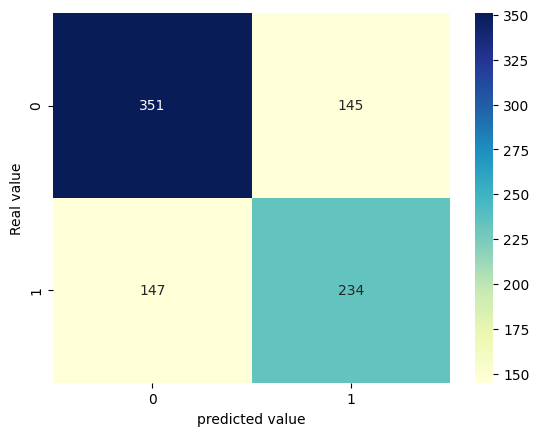

In [166]:
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)

# Обучение модели
criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)

for epoch in range(30):
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Оценка модели
model.eval()
with torch.no_grad():
    total_correct = 0
    predicted_labels = []
    test_labels = []
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        predicted_labels.extend(predicted.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())

# Преобразовать списки в numpy массивы
predicted_labels = np.array(predicted_labels)
test_labels = np.array(test_labels)

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print("Матрица ошибок:")
sns.heatmap(conf_mat,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

# Classification report
print("\nClassification report:")
report = classification_report(test_labels, predicted_labels, output_dict=True)
print(report)

### Меняем количество нейронов в слое

In [167]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, 64, num_layers=2, batch_first=True)
        self.rnn2 = nn.LSTM(64, 32, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn1.num_layers, x.size(0), self.rnn1.hidden_size).to(x.device)
        out, _ = self.rnn1(x, (h0, c0))
        h1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        c1 = torch.zeros(self.rnn2.num_layers, out.size(0), self.rnn2.hidden_size).to(x.device)
        out, _ = self.rnn2(out, (h1, c1))
        out = out[:, -1, :]
        out = self.dropout1(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout2(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout3(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

### Тестирование RNN

f1_score: 0.5832462058529716

Классификационный отчет:
              precision    recall  f1-score   support

           0       0.63      0.62      0.63       496
           1       0.52      0.53      0.53       381

    accuracy                           0.58       877
   macro avg       0.58      0.58      0.58       877
weighted avg       0.58      0.58      0.58       877



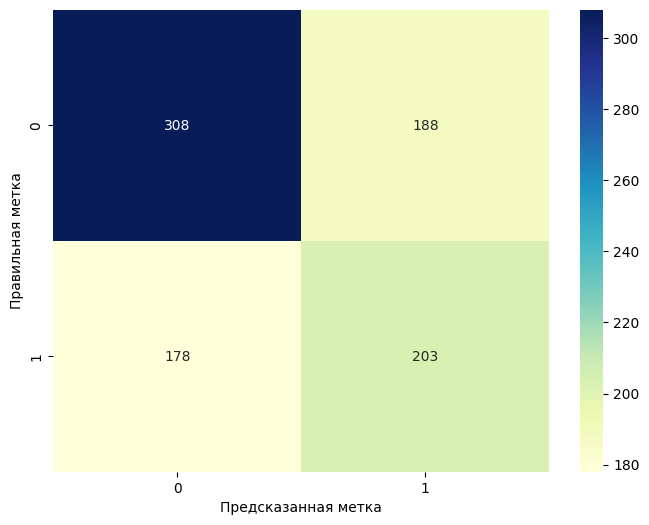

In [168]:
# Определение модели
import torch.optim.rprop


model = RNNModel(input_dim=19, output_dim=2)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Обучение модели
for epoch in range(60):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        labels = labels[:, None]  # добавляем новый размерность
        labels = torch.cat((1 - labels, labels), dim=1)  # преобразуем в бинарный формат
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # print(f'Эпоха {epoch+1}, потеря: {total_loss / len(train_loader)}')

# Оценка модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
predicted_labels = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        labels = labels[:, None]  # добавляем новый размерность
        labels = torch.cat((1 - labels, labels), dim=1)  # преобразуем в бинарный формат
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)  # получаем индекс максимальной вероятности
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        test_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print(f'f1_score: {f1_score(test_labels, predicted_labels, average='weighted')}')

# Классификационный отчет
print("\nКлассификационный отчет:")
print(classification_report(test_labels, predicted_labels))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel("Предсказанная метка")
plt.ylabel("Правильная метка")
plt.show()

### Гибридная RNN

**Создаем датасеты с боями по каждому отдельному бойцу, у которого больше 5 боев в UFC**

In [ ]:
# Выберем все бои, где участовали бойцы минимум с 1 боем за плечами
fights_with_stats = data[((data['RedWins'] + data['RedLosses']) >= 1) & ((data['BlueWins'] + data['BlueLosses']) >= 1)]

# Составим список всех бойцов
fighter_names = set(fights_with_stats.loc[(fights_with_stats['RedWins'] + fights_with_stats['RedLosses']) >= 5, 'RedFighter'].unique()) & \
                set(fights_with_stats.loc[(fights_with_stats['BlueWins'] + fights_with_stats['BlueLosses']) >= 5, 'BlueFighter'].unique())

print(f'Общее число бойцов, у которых более 5 боев: {len(fighter_names)}')

In [ ]:
fights_with_stats

In [71]:
# Теперь составим для каждого бойца список из последних 5 боев с его участием
fighter_fights = {}
for fighter in fighter_names:
    fighter_fights[fighter] = fights_with_stats.loc[(fights_with_stats['RedFighter'] == fighter) | \
                             (fights_with_stats['BlueFighter'] == fighter)].head()

In [ ]:
pd.DataFrame(fighter_fights['Ilia Topuria'])

In [82]:
# Определение датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx]
        y = self.y.iloc[idx]  # берем только первый столбец (класс)
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }  

In [95]:
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [211]:
# Создание общей модели
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out   

# Обучение общей модели
model = RNNModel(input_dim=39, hidden_dim=128, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(10):
    for batch in train_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

In [ ]:
# Оценка модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

accuracy = correct / len(test_dataset)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Tочность на тестовой выборке: {accuracy:.4f}')
print(f'F1-мера на тестовой выборке: {f1:.4f}')
print(f'Precision на тестовой выборке: {precision:.4f}')
print(f'Recall на тестовой выборке: {recall:.4f}')
print(f'Средняя потеря на тестовой выборке: {test_loss / len(test_dataloader):.4f}')

Fine-tune на бойцах с 5+ боями в лиге

In [213]:
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return {
            'x': x,
            'y': y
        }

In [214]:
# Для каждого бойца создайте отдельный датасет
fighter_datasets = {}
fighter_dataloaders = {}
for fighter, fights in fighter_fights.items():
    fighter_df = pd.DataFrame(fights)
    # Нормализуйте данные и преобразуйте их в тензоры
    fighter_X = fighter_df.drop(['RedFighter', 'BlueFighter', 'Result'], axis=1)
    fighter_y = fighter_df['Result']
    fighter_X = torch.tensor(fighter_X.values, dtype=torch.float32)
    fighter_y = torch.tensor(fighter_y.values, dtype=torch.long)
    # Создайте датасет для fine-tuning
    fighter_dataset = FighterDataset(fighter_X, fighter_y)
    # Создайте загрузчик данных для fine-tuning
    fighter_dataloader = DataLoader(fighter_dataset, batch_size=32, shuffle=True)
    # Сохраните датасет и загрузчик в словарях
    fighter_datasets[fighter] = fighter_dataset
    fighter_dataloaders[fighter] = fighter_dataloader

In [215]:
import copy

# Обучение fine-tuned моделей
fighter_models = {}
for fighter, fighter_dataloader in fighter_dataloaders.items():
    # Создайте копию основной модели
    fighter_model = copy.deepcopy(model)
    # Определите критерий и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fighter_model.parameters(), lr=0.001)
    # Обучите fine-tuned модель
    for epoch in range(5):
        for batch in fighter_dataloader:
            x = batch['x'].unsqueeze(1)  # добавляем временную размерность
            y = batch['y']
            optimizer.zero_grad()
            outputs = fighter_model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
    # Сохраните fine-tuned модель в словаре
    fighter_models[fighter] = fighter_model

### Объединение общей и fine-tuned моделей

1. Объединение весов моделей

Этот код объединяет веса основной модели и всех fine-tuned моделей, взвешивая каждую модель по количеству данных, на которых она была обучена. Это позволяет более точно учитывать разницу в размерах данных для каждого бойца.

In [216]:
# Объединение весов моделей
combined_model = model  # основная модель
beta = torch.tensor(1.0)  # экспоненциальный коэффициент
for fighter, fighter_model in fighter_models.items():
    for k in combined_model.state_dict():
        combined_model.state_dict()[k] = (1 / (1 + torch.exp(-beta))) * combined_model.state_dict()[k] + (torch.exp(-beta) / (1 + torch.exp(-beta))) * fighter_model.state_dict()[k]

In [ ]:
# Оценка полученной модели на тестовой выборке
combined_model.eval()
test_loss = 0
correct = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        outputs = combined_model(x)
        loss = nn.CrossEntropyLoss()(outputs, y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

accuracy = correct / len(test_dataset)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Tочность на тестовой выборке: {accuracy:.4f}')
print(f'F1-мера на тестовой выборке: {f1:.4f}')
print(f'Precision на тестовой выборке: {precision:.4f}')
print(f'Recall на тестовой выборке: {recall:.4f}')
print(f'Средняя потеря на тестовой выборке: {test_loss / len(test_dataloader):.4f}')

2. Переобучение основной модели на данных, которые были использованы для fine-tuning

In [218]:
# Создание нового датасета
combined_X = torch.cat([dataset.X for dataset in fighter_datasets.values()])
combined_y = torch.cat([dataset.y for dataset in fighter_datasets.values()])
combined_dataset = FighterDataset(combined_X, combined_y)

# Создание загрузчика данных
combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Переобучение основной модели
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(5):
    for batch in combined_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

In [ ]:
# Оценка полученной модели на тестовой выборке
model.eval()
test_loss = 0
correct = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        x = batch['x'].unsqueeze(1)  # добавляем временную размерность
        y = batch['y']
        outputs = model(x)
        loss = nn.CrossEntropyLoss()(outputs, y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())

accuracy = correct / len(test_dataset)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Tочность на тестовой выборке: {accuracy:.4f}')
print(f'F1-мера на тестовой выборке: {f1:.4f}')
print(f'Precision на тестовой выборке: {precision:.4f}')
print(f'Recall на тестовой выборке: {recall:.4f}')
print(f'Средняя потеря на тестовой выборке: {test_loss / len(test_dataloader):.4f}')

3. Методы ensemble: stacking и bagging, чтобы объединить результаты fine-tuned моделей и создать новую общую модель.

In [222]:
class RNNModelWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # код для обучения модели
        pass

    def predict(self, X):
        # код для предсказания
        X_tensor = torch.tensor(X, dtype=torch.float32)
        X_tensor = X_tensor.unsqueeze(1)  # добавляем временную размерность
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            return predicted.numpy()

In [ ]:
# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


# Создание списка моделей
models = list(fighter_models.values())

# Создание списка оберток для моделей
wrappers = [RNNModelWrapper(model) for model in models]

# Создание списка предсказаний
predictions = []
for model in models:
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        X_test_tensor = X_test_tensor.unsqueeze(1)  # добавляем временную размерность
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.numpy())

# Создание списка уникальных имен для моделей
model_names = [f'model_{i}' for i in range(len(models))]

# Создание stacking-модели
estimators = list(zip(model_names, wrappers))
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Обучение stacking-модели
stacking_model.fit(np.array(predictions).T, y_test.values)